# Benchmarking SimpleColocalization

---

## Contents

- 1. Introduction
    - 
---

This notebook analyses the performance of Simple Colocalisation and other plugins against manual counts.

TODO: justify why/why not ANOVA

## About the data

This analysis is done against nine images of NeuN stained brain tissue in total, comprising the first three series of image sets`22.lif`, `33.lif`, `49.lif`.
Manual counts were collected by all six members of the team (non-experts), and timed in minutes.

[ITCN](https://imagej.nih.gov/ij/plugins/itcn.html) is an existing plugin for ImageJ for counting cells in an image.

I will use SC to refer to SimpleColocalization in the code.

I did not perform any manual preprocessing - the plugins were run directly in the input images. Each plugin was run with appropriate input parameters which were documented (but not repeated here).

## Observations

When collecting the results, I noticed some observations with respect to the overall user experience of each plugin.


1. The ITCN width parameter is very sensitive! It greatly affects the count value.
2. Maybe expects preprocessing? It's hard to tell, because documentation is sparse.
3. ITCN runs much slower, and the whole application freezes while the plugin is running.

## Exploratory Data Analysis

In [206]:
# Import necessary packages.

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [207]:
# Parse input data.

df = pd.read_csv("cell_counts.csv", skiprows=2, header=0)

# Set index and rename columns for readability.
df["Image Set"] = df["Image Set"].fillna(method='ffill').str.replace(".lif", "").astype(int)
df.set_index(keys=["Image Set", "Series"], inplace=True)
df.rename(mapper={"SC (pre-dip lining)": "SC", 
                  "Count": "Student 1", 
                  "Count.1": "Student 2", 
                  "Count.2": "Student 3", 
                  "Count.3": "Student 4", 
                  "Count.4": "Student 5", 
                  "Count.5": "Student 6", 
                  "Time": "Time 1", 
                  "Time.1": "Time 2", 
                  "Time.2": "Time 3", 
                  "Time.3": "Time 4",
                  "Time.4": "Time 5", 
                  "Time.5": "Time 6"}, inplace=True, axis=1)

# Counts obtained by manually counting each image.
manual_counts = df[["Student 1", "Student 2", "Student 3", "Student 4", "Student 5", "Student 6"]]

# Counts obtained by running ITCN with appropriate parameters.
itcn_counts = df[["ITCN"]]

# Counts obtained by running SimpleColocalization with appropriate parameters.
sc_counts = df[["SC"]]

all_counts = pd.concat([manual_counts, itcn_counts, sc_counts], axis=1)

# Manual count timings.
times = df[["Time 1", "Time 2", "Time 3", "Time 4", "Time 5", "Time 6"]]
display(all_counts)

Student 1  Student 2  Student 3  Student 4  Student 5  \
Image Set Series                                                          
22        1            1332        897       1122       1131       1281   
          2             851        580        859        870        868   
          3            1003        606       1115       1010       1162   
33        1             831        596        715        633        829   
          2             632        613        746        817        854   
          3             598        515        502        333        631   
49        1             823        825        792        930        883   
          2             662        631        671        716        643   
          3             935        948       1079       1107       1047   

                  Student 6  ITCN    SC  
Image Set Series                         
22        1             857  1250  1022  
          2             725   744   770  
          3            1092   812   960  
33        1             771   607   865  
          2             771   798   738  
          3             636   777   686  
49        1             784   795   785  
          2             648   753   635  
          3             983   874  1003

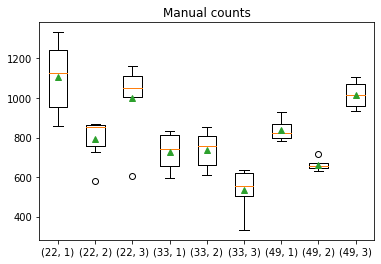

In [208]:
plt.boxplot(manual_counts, labels=df.index, showmeans=True)
plt.title("Manual counts")
plt.show()

In [209]:
mean_manual_counts = pd.DataFrame(manual_counts.mean(axis=1), columns=["Mean Manual Count"])
means = pd.concat([mean_manual_counts, itcn_counts, sc_counts], axis=1)

display(means)

Mean Manual Count  ITCN    SC
Image Set Series                               
22        1             1103.333333  1250  1022
          2              792.166667   744   770
          3              998.000000   812   960
33        1              729.166667   607   865
          2              738.833333   798   738
          3              535.833333   777   686
49        1              839.500000   795   785
          2              661.833333   753   635
          3             1016.500000   874  1003

## Accuracy Analysis

Since we have two categorical IVs (image and plugin type) and one DV (count) we use a two-way ANOVA test. This will tell us if the three methods differ significantly, and then we can perform a post-hoc test if necessary to identity which in particular.

The null hypothesis $H_0$ is that for the overall F-test for this experiment would be that all levels of the factor produce the same response, on average.

We can perform simple linear regression analysis.

We would expect the points to lie on a straight line x = y.

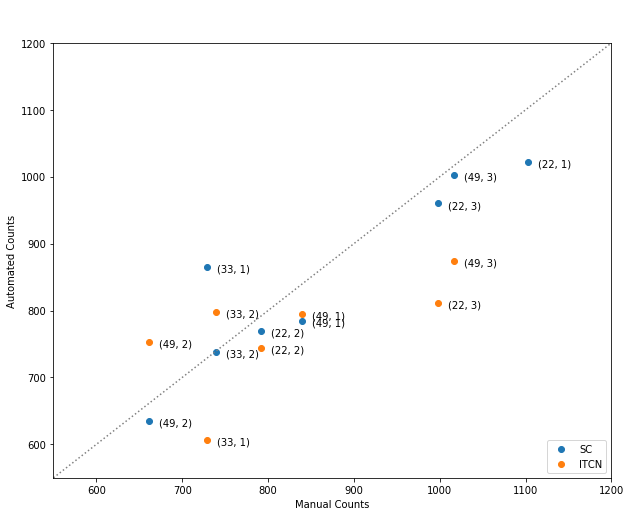

In [244]:
from matplotlib import cm

def plot_and_annotate(col1: pd.Series, col2: pd.Series, ax):
    """
    Plots two columns of a pandas DataFrame on a scatter graph, and annotates 
    each point with the index of the point.
    
    Pre: col1 and col2 must have the same index.
    """
    ax.scatter(col1, col2, label=col2.name)
    
    for index, x in col1.iteritems():
        y = col2[index]
        ax.annotate(s=index, xy=(x, y), xytext=(10,-5), textcoords="offset points")


fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("")
ax.set_xlabel("Manual Counts")
ax.set_ylabel("Automated Counts")

plot_and_annotate(means["Mean Manual Count"], means["SC"], ax)
plot_and_annotate(means["Mean Manual Count"], means["ITCN"], ax)

ax.set_xlim([550, 1200])
ax.set_ylim([550, 1200])
ax.legend(loc="lower right")

# Reference line
ax.plot([550,1200],[550,1200], color="gray", linestyle=":");

In [227]:
# Compute mean squared error

from sklearn.metrics import mean_squared_error

itcn_mse = mean_squared_error(means["Mean Manual Count"], means["ITCN"])
sc_mse = mean_squared_error(means["Mean Manual Count"], means["SC"])

print(f"ITCN MSE: {itcn_mse}")
print(f"SC MSE:   {sc_mse}")

ITCN MSE: 18401.305555555555
SC MSE:   5936.046296296296


### Assumptions

Conventional ANOVA makes three assumptions:

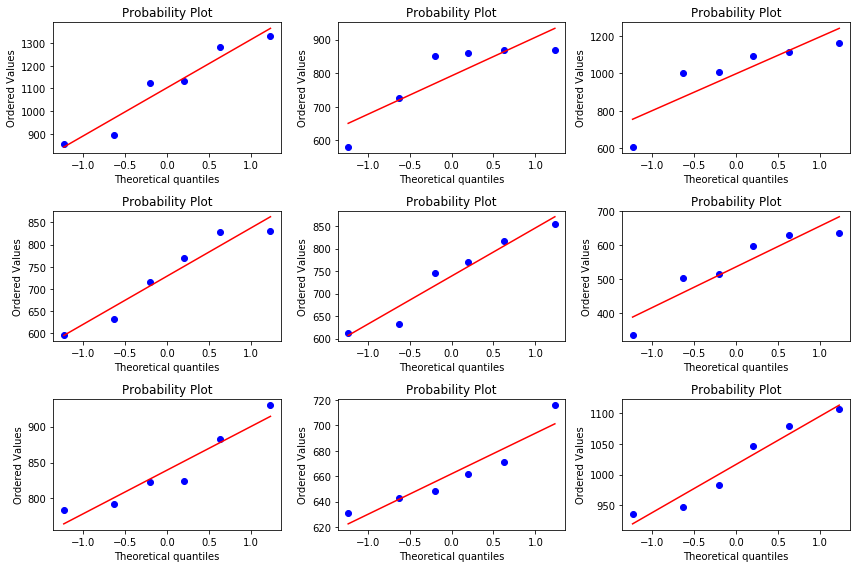

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

for i in range(len(manual_counts.index)):
    stats.probplot(manual_counts.iloc[i], plot=axes[i // 3, i % 3])
    
fig.tight_layout()
plt.show()

From these plots, excepting a few outliers, it seems safe to assume that the manual counts are normally distributed.

In [63]:
means

Mean Manual Count  ITCN    SC
Image Set Series                               
22        1             1103.333333  1250  1022
          2              792.166667   744   770
          3              998.000000   812   960
33        1              729.166667   607   865
          2              738.833333   798   738
          3              535.833333   777   686
49        1              839.500000   795   785
          2              661.833333   753   635
          3             1016.500000   874  1003

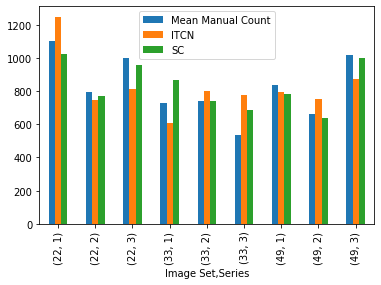

In [68]:
means.plot(kind="bar")

In [6]:
stats.f_oneway(means["Mean Manual Count"], means["ITCN"])

F_onewayResult(statistic=4.5757390577431294e-05, pvalue=0.9946864384759733)

In [7]:
stats.f_oneway(means["Mean Manual Count"], means["SC"])

F_onewayResult(statistic=0.004930040347696231, pvalue=0.9448932421434859)

In [96]:
stats.f_oneway(means["Mean Manual Count"], means["SC"], means["ITCN"])

F_onewayResult(statistic=0.0035008287922751297, pvalue=0.9965058007391896)

## Post-Hoc testing

## Time-efficiency Analysis

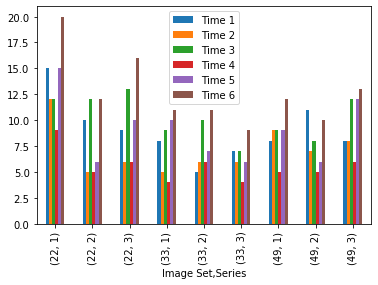

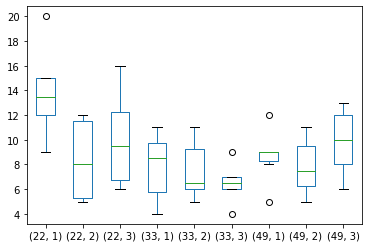

In [107]:
times.plot(kind="bar")
times.T.plot(kind="box")

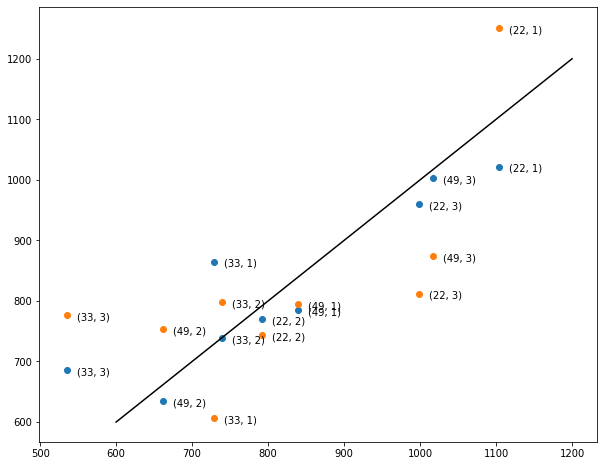